In [137]:
def read_code_from_file(file_path):
    with open(file_path, 'r') as file:
        code = file.read()
    return code

In [138]:
def write_code_to_file(file_path, code):
    with open(file_path, "w") as file:
        file.write(code)

In [139]:
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool

"""
REPL - Read, Eval, Print, Loop, 读取-求值-打印-循环
Langchain 的 PythonREPL 工具让 LLM 可以自己写 Python 代码，而且真正去执行它，然后拿到运行结果
"""

repl = PythonREPL()

@tool
def python_repl(code: Annotated[str, "filename to read the code from"]):
    """
    Use this to execute python code read from a file. 
    """
    try:
        result = repl.run(code)
        print("RESULT CODE EXECUTION:", result)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Executed:\n```python\n{code}\n```\nStdout: {result}"

In [140]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("DEEPSEEK_API_KEY")
if api_key:
    model = ChatOpenAI(
        model="deepseek-chat",
    api_key=api_key,
    base_url="https://api.deepseek.com",
    temperature=0
)
else:
    print("API Key not Found")

# bind_tools 的功能是将 tools 绑定到 model 上
"""
这么做，Langchain 会将Python函数转换成一个LLM能理解的 JSON Schema 格式，模型就可以知道应该调用哪些工具，每个工具的名字、用处、需要的参数、参数的类型。当用户提问时，模型可以：选择直接回答，或选择调用一个或多个工具。如果选择调用工具，模型会返回一个特殊的响应，而不是文本。
"""
model_with_tools = model.bind_tools([python_repl])

In [141]:
messages = [
    SystemMessage(content="""You are a code execution validator.

CRITICAL RULE: You must respond with EXACTLY one word - either 'True' or 'False'.
- Use python_repl tool to execute the code
- If execution succeeds: respond with the single word 'True' (no explanation)
- If execution fails: respond with the single word 'False' (no explanation)

Example good response: True
Example bad response: The code worked successfully, so True

Remember: ONLY output 'True' or 'False', nothing else."""),
    HumanMessage(content="transcript.py")
]

# ai_msg = model_with_tools.invoke(messages)

# 第一次调用后，AI会知道需要调用的工具和参数等等
# messages.append(ai_msg)

In [142]:
# from langchain_core.messages import HumanMessage, ToolMessage

# for tool_call in ai_msg.tool_calls: # 包含 AI 请求调用的所有工具
#     selected_tool = {"python_repl": python_repl}[tool_call["name"].lower()] # 这里会有多此一举的感觉，这么写是为了以后扩展方便
#     tool_output = selected_tool.invoke(tool_call["args"])
#     messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"])) # 第二次调用，工具会执行结果（ToolMessage 接收工具输出和工具调用 ID，返回的是工具消息）

# model_with_tools.invoke(messages) # 第三次调用，AI 基于工具结果生成最终回答。


# Agent

In [143]:
from typing import TypedDict

class AgentState(TypedDict):
    message: str
    succeeded: bool
    error_message: str
    file_path: str
    code: str
    iterations: int

In [144]:
def identify_filepath(state: AgentState):
    message = state["message"]
    messages = [
        SystemMessage(
            content="""Your task is to evaluate the userinput and extract the filename he provided.
                              ONLY return the last filename, nothing else!"""
        ),
        HumanMessage(content=message),
    ]
    result = model.invoke(messages)
    state["file_path"] = result.content
    return state

In [145]:
from langchain_core.messages import HumanMessage, ToolMessage
def execute_code_with_model(state: AgentState):

    code = read_code_from_file(state["file_path"])
    state["code"] = code

    messages = [
        SystemMessage(
            content="""You are a code execution validator.
CRITICAL RULE: You must respond with EXACTLY one word - either 'True' or 'False'.
- Use python_repl tool to execute the code
- If execution succeeds: respond with the single word 'True' (no explanation)
- If execution fails: respond with the single word 'False' (no explanation)

Example good response: True
Example bad response: The code worked successfully, so True

Remember: ONLY output 'True' or 'False', nothing else."""
        ),
        HumanMessage(content=code),
    ]

    ai_msg = model_with_tools.invoke(messages)
    messages.append(ai_msg)

    for tool_call in ai_msg.tool_calls:
        selected_tool = {"python_repl": python_repl}[tool_call["name"].lower()]
        tool_output = selected_tool.invoke(tool_call["args"])
        state["error_message"] = tool_output
        messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

    # 添加一个明确的提示，告诉 AI 现在要回答了
    messages.append(
        HumanMessage(content="Based on the tool execution result above, respond with ONLY 'True' or 'False'. Do NOT call any tools again.")
    )
    result = model_with_tools.invoke(messages)
    print("EVALUATION RESULT:", result)
    print("Content:", result.content)
    print("Tool calls:", result.tool_calls)  # 添加这行！
    state["succeeded"] = result.content
    return state


def rewrite_code(state: AgentState):
    print("---------REWRITE---------")
    code = state["code"]
    error = state["error_message"]
    state["iterations"] += 1
    # model = model
    messages = [
        SystemMessage(
            content="You can to analyze the following code and error provided in the usermessage. Your task is to fix that code and provide the user the correct new code. VERY IMPORTANT: ONLY RETURN THE UPDATED CODE, NOTHING ELSE! Dont use a markdown style, just the code as Text"
        ),
        HumanMessage(content=f"Code: {code} | Error: {error}"),
    ]
    ai_msg = model.invoke(messages)
    # print("NEW SUGGESTED CODE:", ai_msg.content)
    write_code_to_file(file_path=f'{state["file_path"]}', code=ai_msg.content)
    state["code"] = ai_msg.content
    return state


def next_step(state: AgentState):
    print("---------NEXT STEP---------")
    print(state)
    if state["iterations"] > 3:
        print("Max Iterations done.... Exit Agent")
        return "max_iterations"
    if state["succeeded"] == "False":
        print(f"Error in {state['file_path']}. {state['iterations']} tries done")
        return "error"
    if state["succeeded"] == "True":
        print(
            f"Code was probably fixed... check out {state['file_path']} if it is correct"
        )
        return "ok"

In [146]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("identify_filepath", identify_filepath)
workflow.add_node("execute_code_with_model", execute_code_with_model)
workflow.add_node("rewrite_code", rewrite_code)

workflow.set_entry_point("identify_filepath")
workflow.add_edge("identify_filepath", "execute_code_with_model")

workflow.add_conditional_edges(
    "execute_code_with_model",
    next_step,
    {"error": "rewrite_code", "ok": END, "max_iterations": END},
)
workflow.add_edge("rewrite_code", "execute_code_with_model")
app = workflow.compile()

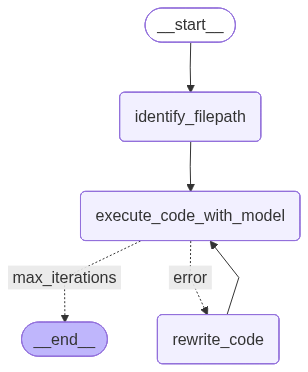

In [147]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [148]:
app.invoke({"message": "Please analyze the transcript.py file", "iterations": 2})

RESULT CODE EXECUTION: TypeError("unsupported operand type(s) for +: 'int' and 'str'")
EVALUATION RESULT: content='False' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 581, 'total_tokens': 582, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 448}, 'prompt_cache_hit_tokens': 448, 'prompt_cache_miss_tokens': 133}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '5ef552b9-c83a-46b8-8bc6-b5cd1f683c3d', 'finish_reason': 'stop', 'logprobs': None} id='lc_run--019aee23-497e-7800-9d1e-3c6737facf0d-0' usage_metadata={'input_tokens': 581, 'output_tokens': 1, 'total_tokens': 582, 'input_token_details': {'cache_read': 448}, 'output_token_details': {}}
Content: False
Tool calls: []
---------NEXT STEP---------
{'message': 'Please analyze the transcript.py file', 'succeeded': 'False', 'error_message': 'Execute

{'message': 'Please analyze the transcript.py file',
 'succeeded': 'True',
 'error_message': 'Executed:\n```python\nx = 2\ny = "test"\nprint(str(x) + y)\n```\nStdout: 2test\n',
 'file_path': 'transcript.py',
 'code': 'x = 2\ny = "test"\nprint(str(x) + y)',
 'iterations': 3}